In [2]:
import scipy.io
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib notebook

from IPython.display import clear_output
import os

from scipy.ndimage import convolve

In [3]:
def get_bw_avg(cams):
    camsbw = []  # black and white videos
    camavgs = []  # average frame in each video
    for i, cam in enumerate(cams):
        cambw = cam[:, :, 0, :] * 0.2989 + cam[:, :, 1, :] * 0.5870 + cam[:, :, 2, :] * 0.1140  # convert to grayscale
        camsbw.append(cambw)
        print("bw:", cambw.shape)
        camavg = np.mean(cambw, axis=2)
        camavgs.append(camavg)
    return camsbw, camavgs

In [56]:
def preprocess(camsbw, camavgs, filts, kernel, step=1, offset=2):
    camsdiff = []  # difference between one time step and the next
    filtereds = []
    for i, cambw in enumerate(camsbw):
        filtered = np.zeros((cambw.shape[0], cambw.shape[1], cambw.shape[2] // step))
        for t in range(0, cambw.shape[-1], step):
            filtered[:, :, t // step] = convolve(abs(cambw[:, :, t] - camavgs[i]), kernel) * filts[i]
        camdiff = abs(filtered[:, :, offset:] - filtered[:, :, :-offset])
        camsdiff.append(camdiff)
        filtereds.append(filtered)
    #     camsdiff.append(abs(cambw[:, :, 1:] - cambw[:, :, :-1]) * cambw[:, :, :-1])
    return camsdiff, filtereds

In [146]:
def extract_location(camsdiff, mn=500, md=1000, dist_weight=10):
    tmax = camsdiff[0].shape[-1]
    grids = []
    for cam in camsdiff:
        grids.append(np.meshgrid(np.arange(cam.shape[1]), np.arange(cam.shape[0])))
    X = []
    i0, j0 = np.unravel_index(np.argmax(camsdiff[0][:,:,0]), camsdiff[0].shape[:2])
    i1, j1 = np.unravel_index(np.argmax(camsdiff[1][:,:,0]), camsdiff[1].shape[:2])
    i2, j2 = np.unravel_index(np.argmax(camsdiff[2][:,:,0]), camsdiff[2].shape[:2])
    X.append(np.array([i0, j0, i1, j1, i2, j2]))
    for t in range(1, tmax):
        i0, j0 = np.unravel_index(np.argmax(camsdiff[0][:,:,t] - dist_weight * ((grids[0][1] - X[-1][0])**2 + (grids[0][0] - X[-1][1])**2)), camsdiff[0].shape[:2])
        i1, j1 = np.unravel_index(np.argmax(camsdiff[1][:,:,t] - dist_weight * ((grids[1][1] - X[-1][2])**2 + (grids[1][0] - X[-1][3])**2)), camsdiff[1].shape[:2])
        i2, j2 = np.unravel_index(np.argmax(camsdiff[2][:,:,t] - dist_weight * ((grids[2][1] - X[-1][4])**2 + (grids[2][0] - X[-1][5])**2)), camsdiff[2].shape[:2])
        if len(X) > 1 and (i0 - X[-1][0])**2 + (j0 - X[-1][1])**2 > md**2:
            i0 = X[-1][0] + (X[-1][0] - X[-2][0]) // 2
            j0 = X[-1][1] + (X[-1][1] - X[-2][1]) // 2
        if len(X) > 1 and (i1 - X[-1][2])**2 + (j1 - X[-1][3])**2 > md**2:
            i1 = X[-1][2] + (X[-1][2] - X[-2][2]) // 2
            j1 = X[-1][3] + (X[-1][3] - X[-2][3]) // 2
        if len(X) > 1 and (i2 - X[-1][4])**2 + (j2 - X[-1][5])**2 > md**2:
            i2 = X[-1][4] + (X[-1][4] - X[-2][4]) // 2
            j2 = X[-1][5] + (X[-1][5] - X[-2][5]) // 2 

#         if camsdiff[0][i0, j0, t] > mn and camsdiff[1][i1, j1, t] > mn and camsdiff[2][i2, j2, t] > mn:
        X.append(np.array([i0, j0, i1, j1, i2, j2]))
#         elif X:
#             X.append(X[-1])
            
    return np.transpose(np.array(X, dtype=np.float32))

In [68]:
def get_filter(xw, yw, scalex=400, scaley=400):
    filtY2, filtX2 = np.meshgrid(np.arange(yw), np.arange(xw))
    filt = np.exp( -(filtX2 - xw/2)**2 / scalex**2 - (filtY2 - yw/2)**2 / scaley**2)
    %matplotlib inline 
    plt.figure()
    plt.imshow(filt)
    plt.show()
    return filt

In [7]:
width = 10
kernelX, kernelY = np.meshgrid(np.arange(-width, width), np.arange(-width, width))
scale = 6
kernel = np.exp( -(kernelX)**2 / scale**2 - (kernelY)**2 / scale**2)

# Setup 1

In [18]:
cam11 = scipy.io.loadmat("./cam1_1.mat")  # loads matlab files into python as a dict of np.ndarrays
cam11 = cam11["vidFrames1_1"].astype(np.float32)
cam21 = scipy.io.loadmat("./cam2_1.mat")["vidFrames2_1"].astype(np.float32)
cam31 = scipy.io.loadmat("./cam3_1.mat")["vidFrames3_1"].astype(np.float32)
cams = [cam11[:, :, :, 10:226], cam21[:, :, :, 17:233], cam31[:, :, :, 10:226]]

IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

In [ ]:
camsbw, camavgs = get_bw_avg(cams)

In [ ]:
camsdiff = preprocess(camsbw, camavgs, filt, kernel)

In [ ]:
%matplotlib inline 
fig = plt.figure()
ax = fig.gca()
plt.imshow(camavgs[0], cmap="gray")
plt.show()
for i in range(0, 15, 1):
#     plt.imshow(np.log(abs(camsbw[0][:,:,i + 1] - camsbw[0][:,:,i]) + 1))
    plt.imshow(camsdiff[0][:,:,i])
    plt.colorbar()
    plt.show()
    plt.imshow(camsbw[0][:,:,i], cmap="gray")
    plt.show()

In [11]:
X = extract_location(camsdiff)

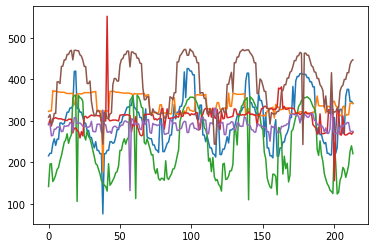

In [12]:
plt.figure()
plt.plot(np.transpose(X)[:, :])
plt.show()

In [14]:
cov = X @ np.transpose(X) / (X.shape[-1] - 1)
L, V = np.linalg.eig(cov)
Y = np.transpose(V) @ X
covY = Y @ np.transpose(Y)

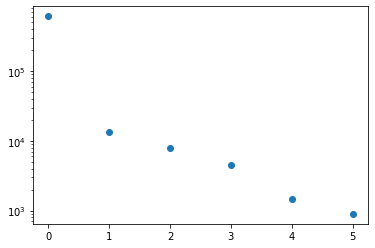

In [103]:
plt.figure()
plt.scatter(np.arange(len(L)), L)
plt.semilogy()
plt.show()

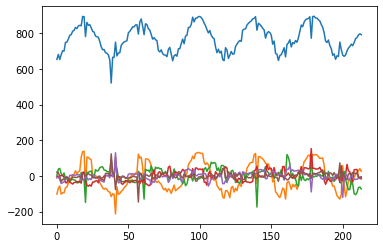

In [17]:
plt.figure()
plt.plot(np.transpose(Y))
plt.show()

# Setup 2 Camera Shake
don't do any diffing frame to frame

In [16]:
cam12 = scipy.io.loadmat("./cam1_2.mat")["vidFrames1_2"].astype(np.float32)
cam22 = scipy.io.loadmat("./cam2_2.mat")["vidFrames2_2"].astype(np.float32)
cam32 = scipy.io.loadmat("./cam3_2.mat")["vidFrames3_2"].astype(np.float32)

In [127]:
cams2 = [cam12[:, :480, :, 4:314], cam22[:, :480, :, 11:321], cam32[150:, :, :, 7:317]]
camsbw, camavgs = get_bw_avg(cams2)

bw: (480, 640, 310)
bw: (480, 640, 310)
bw: (480, 640, 310)


In [128]:
camsdiff = preprocess(camsbw, camavgs, filt, kernel)

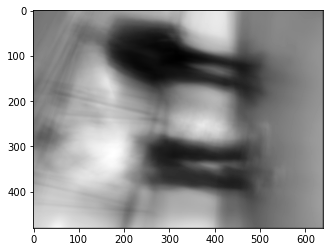

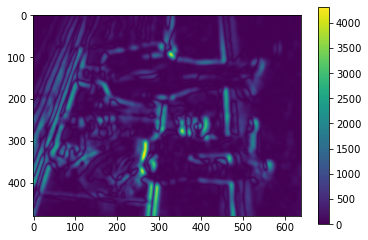

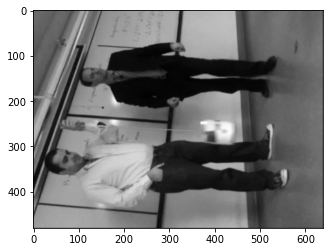

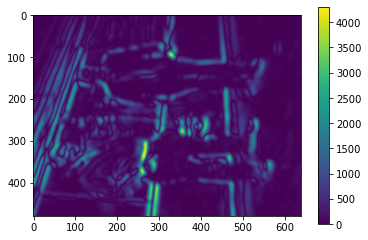

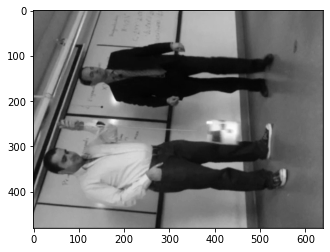

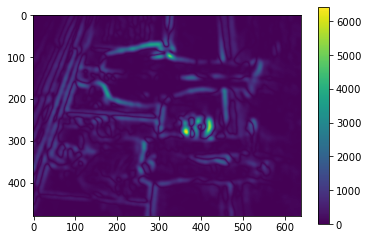

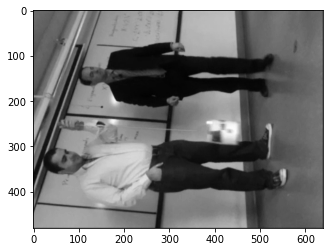

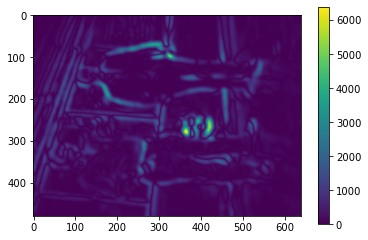

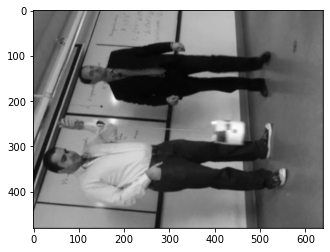

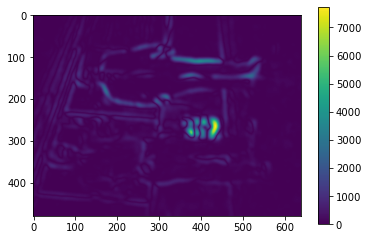

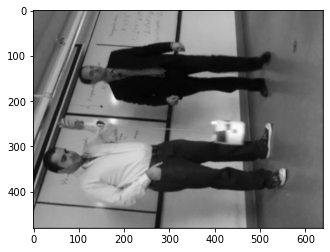

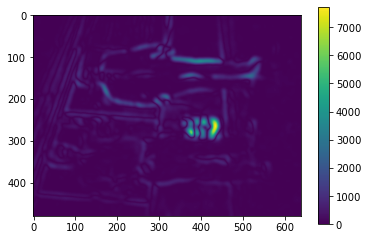

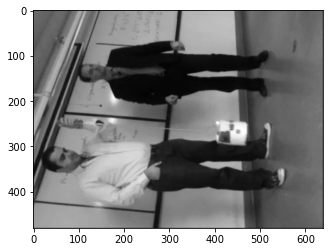

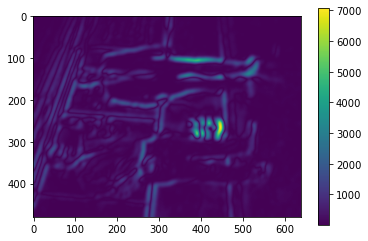

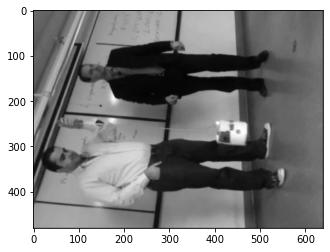

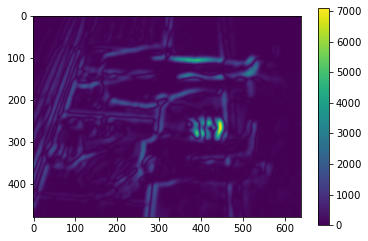

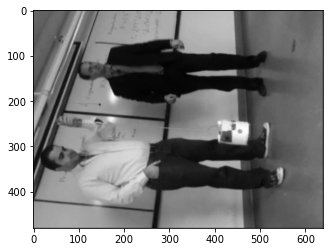

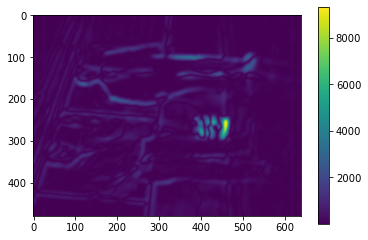

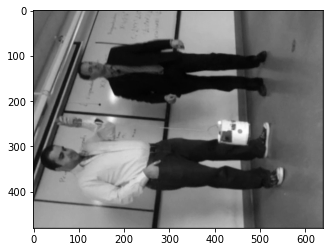

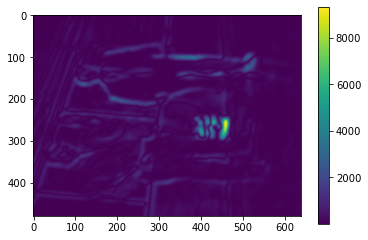

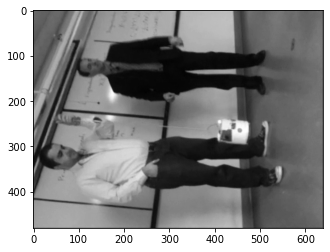

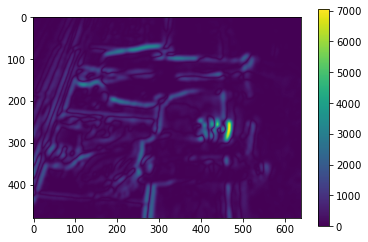

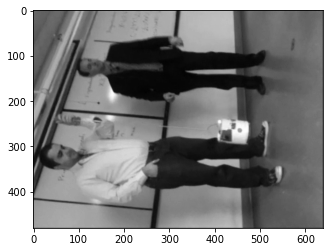

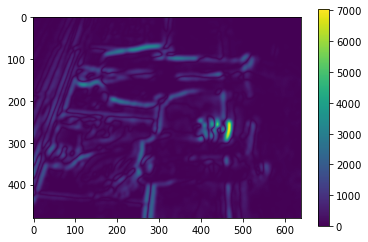

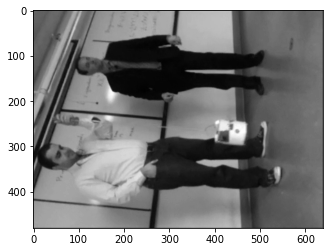

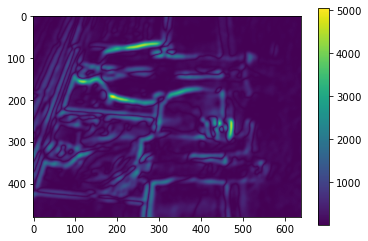

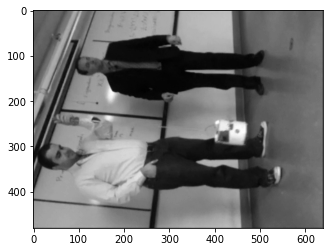

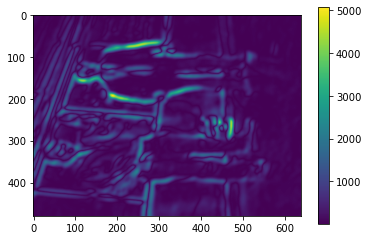

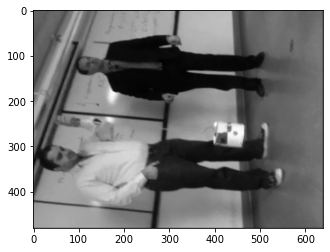

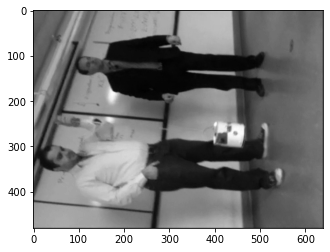

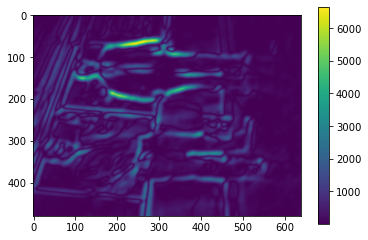

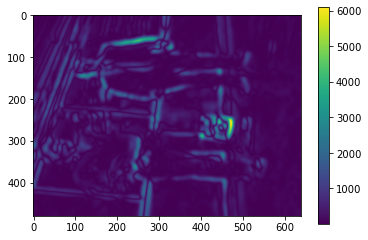

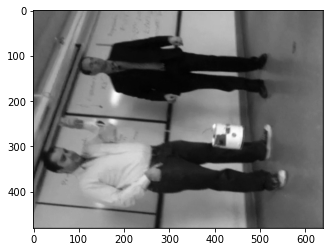

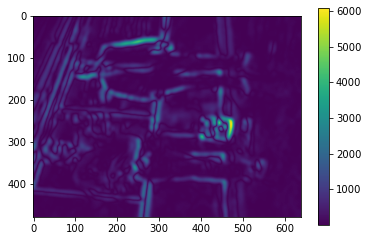

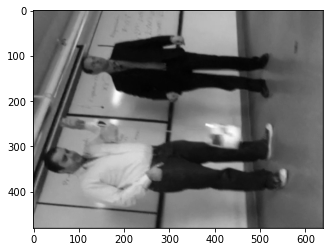

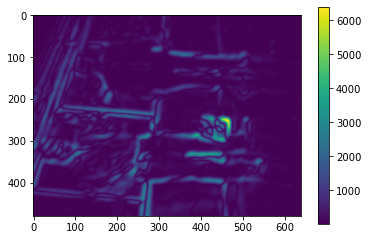

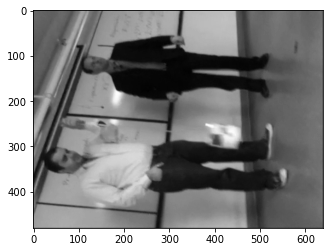

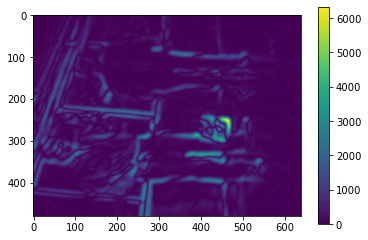

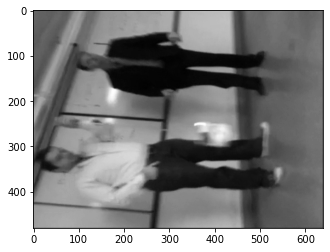

In [129]:
%matplotlib inline 
fig = plt.figure()
ax = fig.gca()
plt.imshow(camavgs[2], cmap="gray")
plt.show()
for i in range(0, 20, 1):
#     plt.imshow(np.log(abs(camsbw[0][:,:,i + 1] - camsbw[0][:,:,i]) + 1))
    plt.imshow(camsdiff[2][:,:,i])
    plt.colorbar()
    plt.show()
    plt.imshow(camsbw[2][:,:,i], cmap="gray")
    plt.show()

In [130]:
X = extract_location(camsdiff, md=700)

<IPython.core.display.Javascript object>


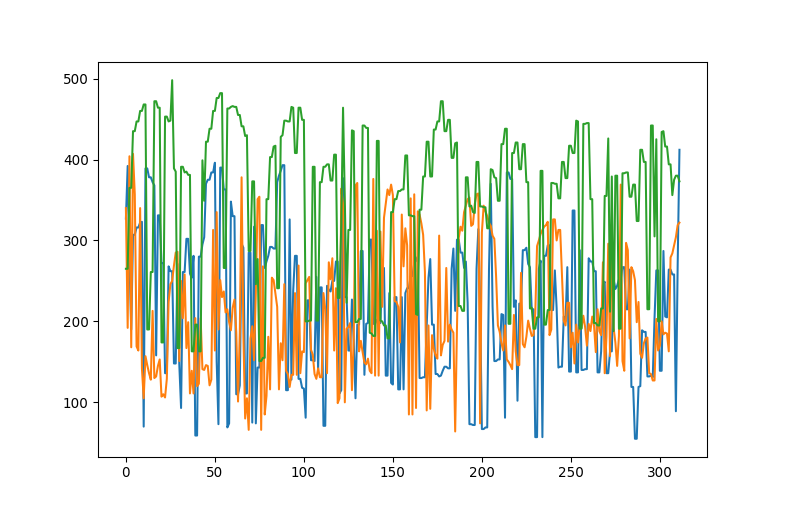

In [131]:
%matplotlib notebook
plt.figure()
plt.plot(np.transpose(X)[:, [0, 2, 5]])
plt.show()

In [29]:
cov = X @ np.transpose(X) / (X.shape[-1] - 1)
L, V = np.linalg.eig(cov)
Y = np.transpose(V) @ X
covY = Y @ np.transpose(Y)

In [30]:
L

array([612445.7   ,   8265.245 ,   6348.7393,   3165.9143,   1446.7023,
         2076.618 ], dtype=float32)

<IPython.core.display.Javascript object>


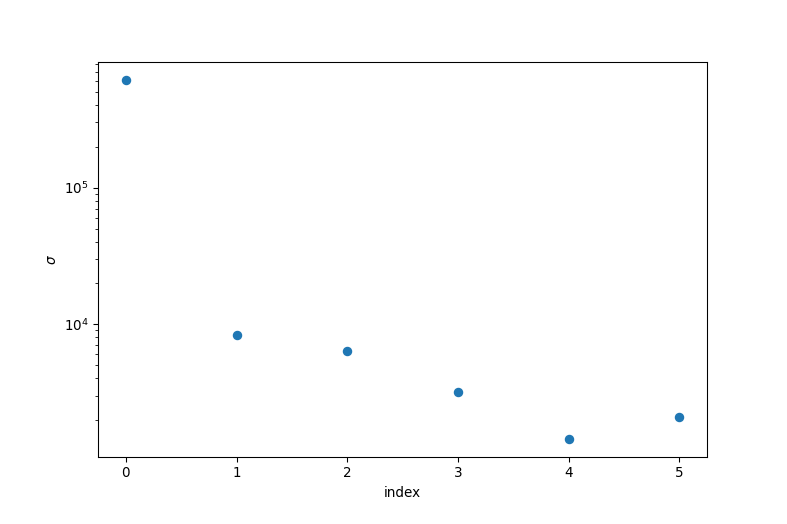

In [27]:
plt.figure()
plt.scatter(np.arange(len(L)), L)
plt.semilogy()
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.show()

<IPython.core.display.Javascript object>


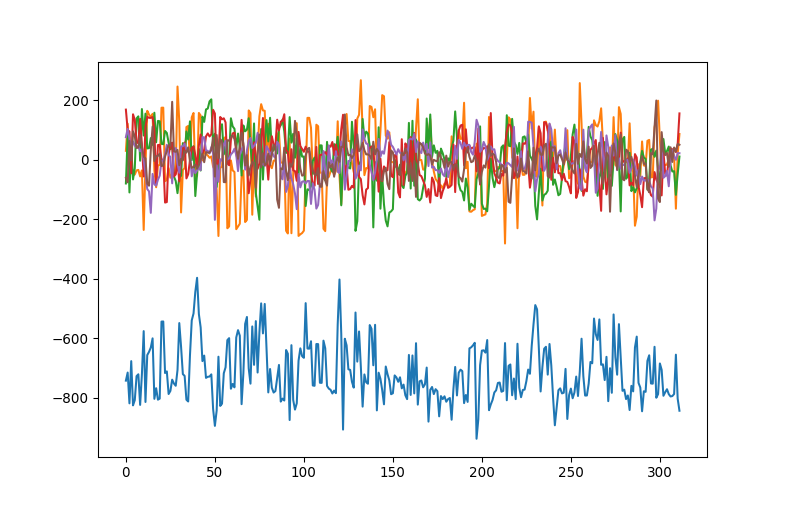

In [134]:
plt.figure()
plt.plot(np.transpose(Y))
plt.show()

# Setup 3 Oscillation and Pendulum

In [58]:
cam13 = scipy.io.loadmat("./cam1_3.mat")["vidFrames1_3"].astype(np.float32)
cam23 = scipy.io.loadmat("./cam2_3.mat")["vidFrames2_3"].astype(np.float32)
cam33 = scipy.io.loadmat("./cam3_3.mat")["vidFrames3_3"].astype(np.float32)

In [77]:
cams3 = [cam13[:, :450, :, 19:239], cam23[:, :450, :, 6:226], cam33[200:, :, :, :220]]
camsbw, camavgs = get_bw_avg(cams3)

bw: (480, 450, 220)
bw: (480, 450, 220)
bw: (280, 640, 220)


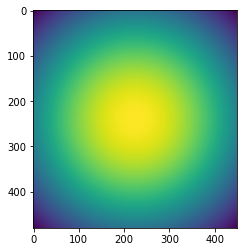

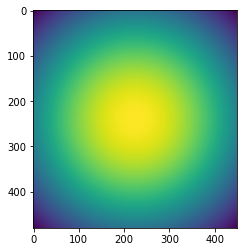

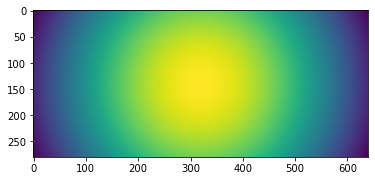

In [78]:
filt13 = get_filter(cams3[0].shape[0], cams3[0].shape[1], scalex=400, scaley=400)
filt23 = get_filter(cams3[1].shape[0], cams3[1].shape[1], scalex=400, scaley=400)
filt33 = get_filter(cams3[2].shape[0], cams3[2].shape[1], scalex=400, scaley=400)

In [79]:
camsdiff, filtered = preprocess(camsbw, camavgs, [filt13, filt23, filt33], kernel, offset=4, step=2)

In [80]:
camsdiff = []
for i, cambw in enumerate(camsbw):
    camdiff = abs(filtered[i][:, :, 2:] - filtered[i][:, :, :-2])
    camsdiff.append(camdiff)

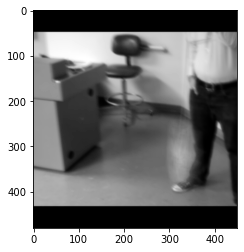

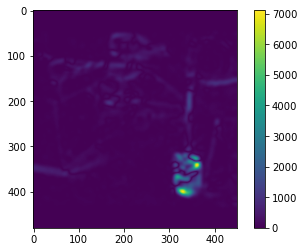

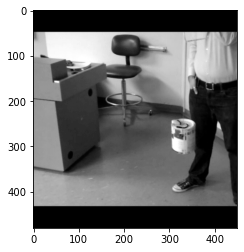

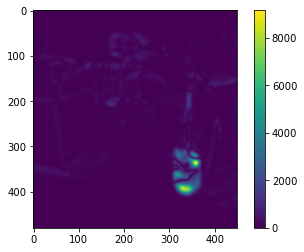

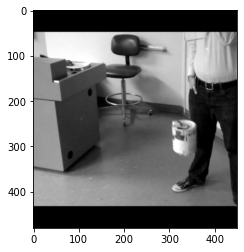

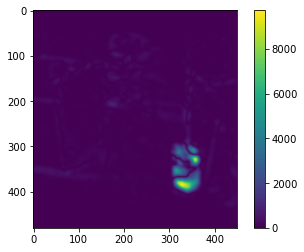

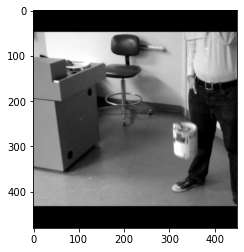

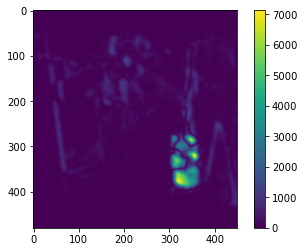

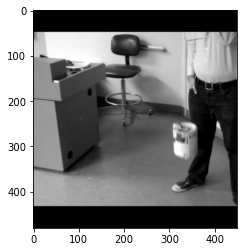

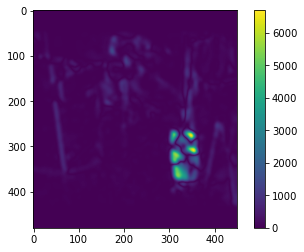

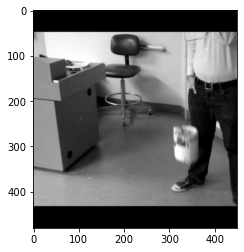

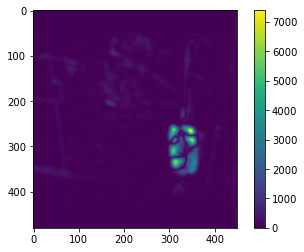

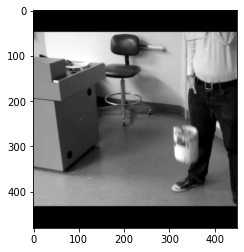

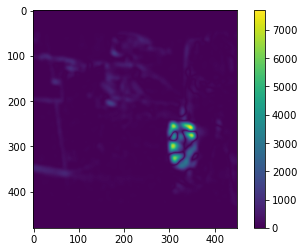

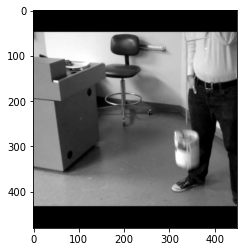

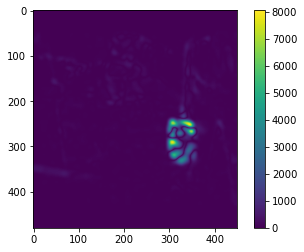

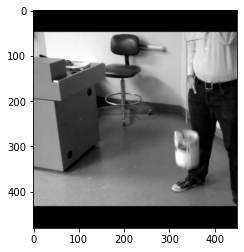

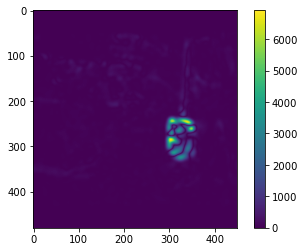

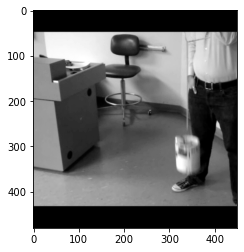

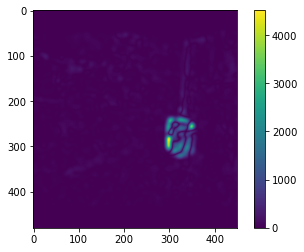

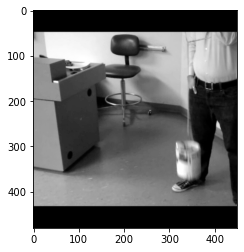

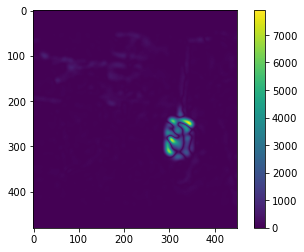

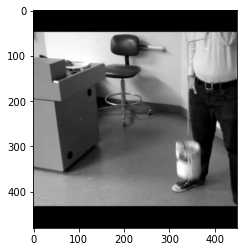

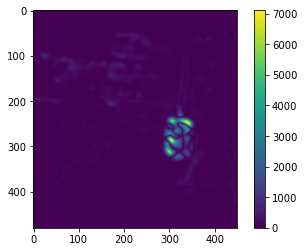

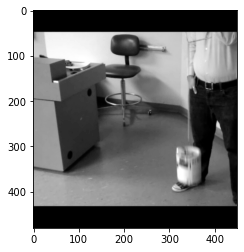

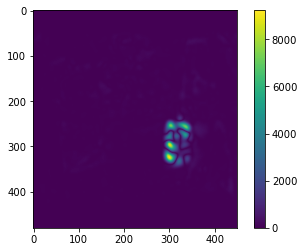

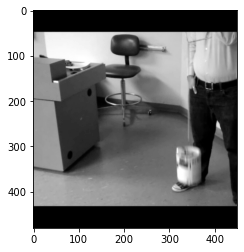

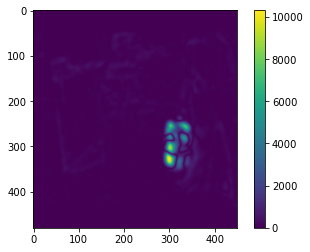

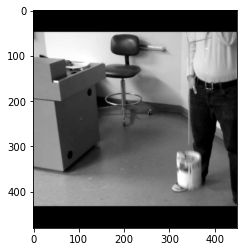

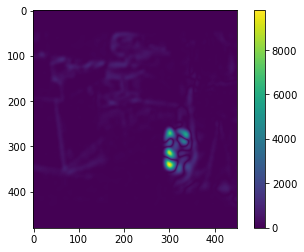

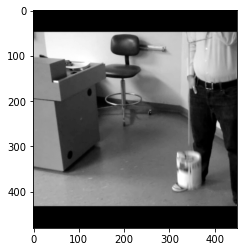

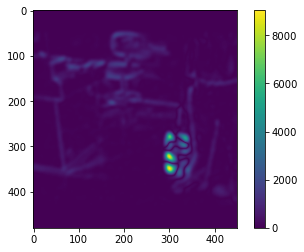

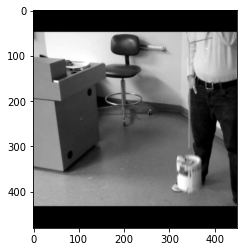

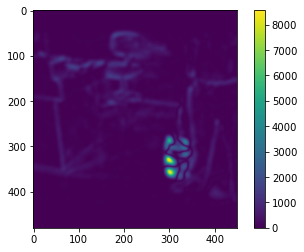

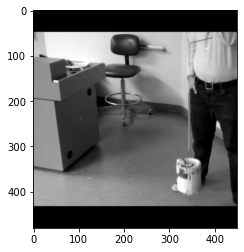

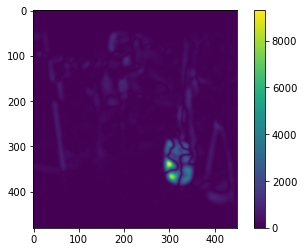

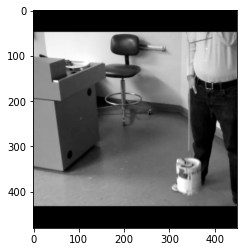

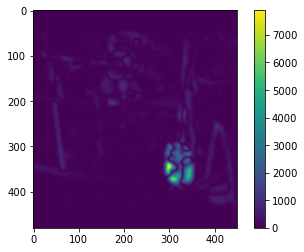

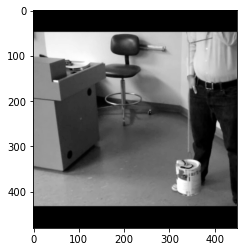

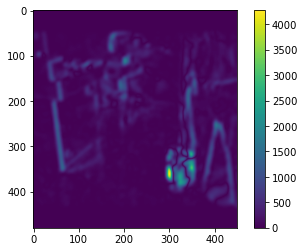

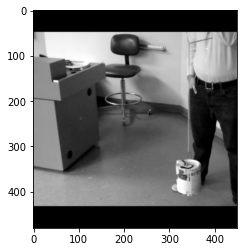

In [96]:
%matplotlib inline 
fig = plt.figure()
ax = fig.gca()
plt.imshow(camavgs[0], cmap="gray")
plt.show()
for i in range(20, 40, 1):
#     plt.imshow(np.log(abs(camsbw[0][:,:,i + 1] - camsbw[0][:,:,i]) + 1))
    plt.imshow(camsdiff[0][:,:,i])
    plt.colorbar()
    plt.show()
    plt.imshow(camsbw[0][:,:,i], cmap="gray")
    plt.show()

In [147]:
X = extract_location(camsdiff, dist_weight=0.5)

<IPython.core.display.Javascript object>


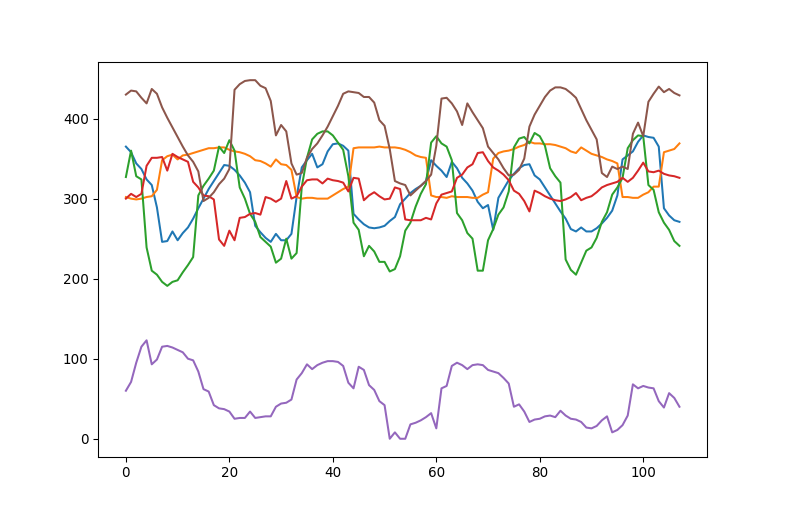

In [148]:
%matplotlib notebook
plt.figure()
plt.plot(np.transpose(X)[:, :])
plt.show()

In [149]:
cov = X @ np.transpose(X) / (X.shape[-1] - 1)
L, V = np.linalg.eig(cov)
Y = np.transpose(V) @ X
covY = Y @ np.transpose(Y)

<IPython.core.display.Javascript object>


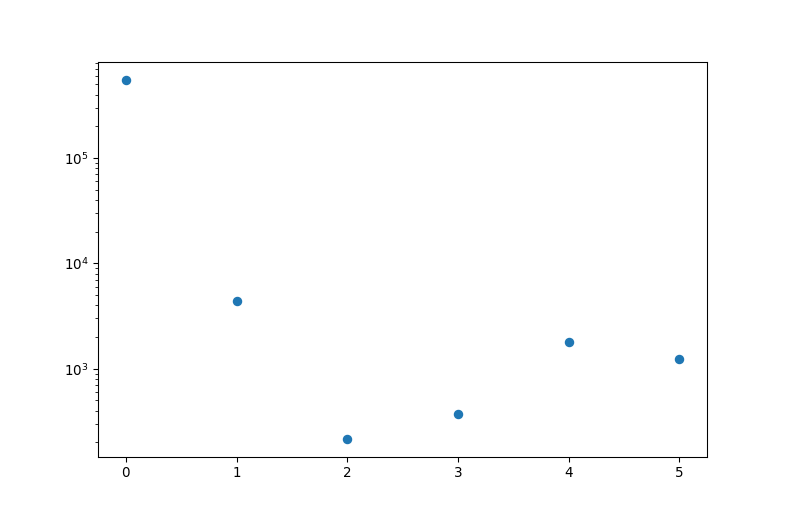

In [150]:
plt.figure()
plt.scatter(np.arange(len(L)), L)
plt.semilogy()
plt.show()

<IPython.core.display.Javascript object>


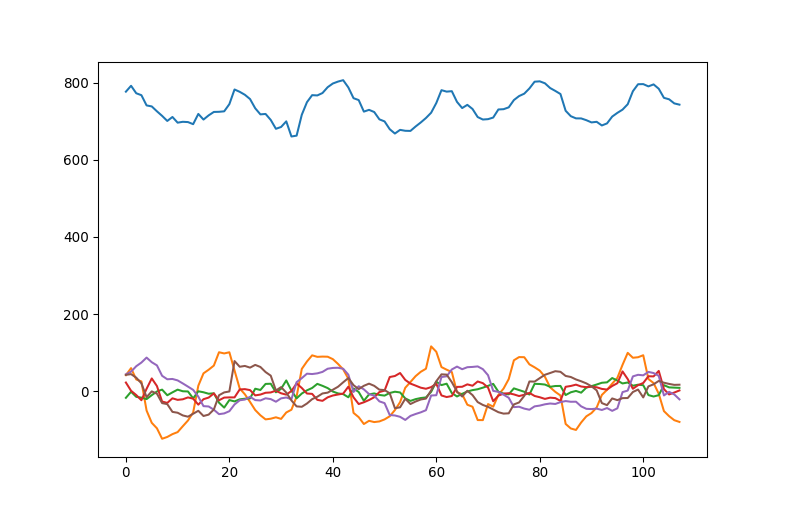

In [152]:
plt.figure()
plt.plot(np.transpose(Y))
plt.show()

# Setup 4 Oscillation and Rotation